### Initial setup

In [1]:
#Import libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import theano.tensor as tt
import arviz as az
import pymc3 as pm

import warnings
warnings.simplefilter(action="ignore")

print("Packages uploaded successfully!")

Packages uploaded successfully!


### Data preparation

In [2]:
#Read data
data = pd.read_csv('/Users/nicospinu/bayesian-dnt/machine_readable_dnt.csv')

In [3]:
#Standardise continuous values
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

#Add other discrete values and details
discrete = data [['ID', 'Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

In [4]:
# ### Define predictors and outcomes

#BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['SLogP', 'Cbrain/Cblood', 'BBB', 
                            'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF, Reduction']]).values

#Syn
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
y_syn = pd.DataFrame(data[['Activity_Syn']]).values

#NNF
x_nnf = pd.DataFrame(data[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
y_nnf = pd.DataFrame(data[['Activity_NNF']]).values

#x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
y_dnt = pd.DataFrame(data[['DNT']]).values

In [5]:
# ### Strategy one: imputation in Bayesian way

## Mask missing values 

#BDNF
x_bdnf_missing = np.isnan(x_bdnf)
X_bdnf_train = np.ma.masked_array(x_bdnf, mask=x_bdnf_missing)
y_bdnf_missing = np.isnan(y_bdnf)
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

#Syn
x_syn_missing = np.isnan(x_syn)
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)
y_syn_missing = np.isnan(y_syn)
Y_syn_train = np.ma.masked_array(y_syn, mask=y_syn_missing)

#NNF
x_nnf_missing = np.isnan(x_nnf)
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)
y_nnf_missing = np.isnan(y_nnf)
Y_nnf_train = np.ma.masked_array(y_nnf, mask=y_nnf_missing)

#DNT
y_dnt_missing = np.isnan(y_dnt)
Y_dnt_train = np.ma.masked_array(y_dnt, mask=y_dnt_missing)

In [6]:
# ### Strategy two: imputation given by the mean

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

#BDNF
imp_mean.fit(X_bdnf_train)
X_bdnf = imp_mean.transform(x_bdnf_missing)
imp_mean.fit(Y_bdnf_train)
Y_bdnf = imp_mean.transform(y_bdnf_missing)

#Syn
imp_mean.fit(X_syn_train)
X_syn = imp_mean.transform(x_syn_missing)
imp_mean.fit(Y_syn_train)
Y_syn = imp_mean.transform(y_syn_missing)

#NNF
imp_mean.fit(X_nnf_train)
X_nnf = imp_mean.transform(x_nnf_missing)
imp_mean.fit(Y_bdnf_train)
Y_nnf = imp_mean.transform(y_nnf_missing)

#DNT
imp_mean.fit(Y_dnt_train)
Y_dnt = imp_mean.transform(y_dnt_missing)

### Define and fit the model for strategy I

In [7]:
with pm.Model() as hierar_model1:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    #Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [8]:
# ## Define bndf 
with hierar_model1: 
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sd=1, shape=(1,6))
    Xsigma_bdnf = pm.HalfNormal('Xsigma_bdnf', sd=2, shape=(1,6))
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', mu=Xmu_bdnf, sd=Xsigma_bdnf, observed=X_bdnf_train)

    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_modelled, beta_bdnf)) 
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)

In [9]:
# ## Define syn
with hierar_model1:
    # Imputation of X missing values for Syn
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=1, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=2, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled', mu=Xmu_syn, sd=Xsigma_syn, observed=X_syn_train)
   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_modelled, beta_syn))    
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p = lp_syn, observed=Y_syn_train)

In [10]:
# ## Define nnf
with hierar_model1:
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=1, shape=(1,3))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=2, shape=(1,3)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled', mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf_train)

In [11]:
# ## Define DNT
with hierar_model1:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt_train)

In [12]:
#Checking the proposed structure of model
hierar_model1.check_test_point()

mu_beta                      3.69
sd_beta_log__               -0.77
beta_bdnf                  -13.82
beta_syn                    -4.61
beta_nnf                    -6.91
Xmu_bdnf                    -5.51
Xsigma_bdnf_log__           -4.62
X_bdnf_modelled_missing      0.00
y_obs_bdnf_missing           0.00
Xmu_syn                     -1.84
Xsigma_syn_log__            -1.54
X_syn_modelled_missing       0.00
Xmu_nnf                     -2.76
Xsigma_nnf_log__            -2.31
X_nnf_modelled_missing       0.00
X_bdnf_modelled           -863.18
y_obs_bdnf                 -67.24
X_syn_modelled            -295.25
y_obs_syn                  -67.24
X_nnf_modelled            -452.70
y_obs_nnf                  -67.24
y_obs_dnt                  -67.24
Name: Log-probability of test_point, dtype: float64

In [13]:
#Compute prior distribution

#ERROR related to shape

with hierar_model1:
    prior_all = pm.sample_prior_predictive(1000)

ValueError: shape mismatch: value array of shape (6,) could not be broadcast to indexing result of shape (115,)
Apply node that caused the error: AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True}(TensorConstant{[[-8.71893..0000e+20]]}, X_bdnf_modelled_missing, TensorConstant{[24 24 24 .. 96 96 96]}, TensorConstant{[1 3 4 5 0..
 2 3 4 5]})
Toposort index: 1
Inputs types: [TensorType(float64, matrix), TensorType(float64, vector), TensorType(int64, vector), TensorType(int64, vector)]
Inputs shapes: [(97, 6), (6,), (115,), (115,)]
Inputs strides: [(8, 776), (8,), (16,), (16,)]
Inputs values: ['not shown', 'not shown', 'not shown', 'not shown']
Outputs clients: [[CGemv{inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, X_bdnf_modelled, InplaceDimShuffle{0}.0, TensorConstant{0.0})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/nicospinu/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3145, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/nicospinu/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/nicospinu/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-448b34545fc9>", line 6, in <module>
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', mu=Xmu_bdnf, sd=Xsigma_bdnf, observed=X_bdnf_train)
  File "/usr/local/lib/python3.8/site-packages/pymc3/distributions/distribution.py", line 83, in __new__
    return model.Var(name, dist, data, total_size, dims=dims)
  File "/usr/local/lib/python3.8/site-packages/pymc3/model.py", line 1112, in Var
    var = ObservedRV(
  File "/usr/local/lib/python3.8/site-packages/pymc3/model.py", line 1737, in __init__
    data = as_tensor(data, name, model, distribution)
  File "/usr/local/lib/python3.8/site-packages/pymc3/model.py", line 1683, in as_tensor
    dataTensor = tt.set_subtensor(constant[data.mask.nonzero()], missing_values)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [14]:
#Make the inferences
with hierar_model1:
    trace = pm.sample(cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


In [15]:
#Compute posterior distributions
with hierar_model1:
    posterior_all = pm.sample_posterior_predictive(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa99262160>,
      dtype=object)

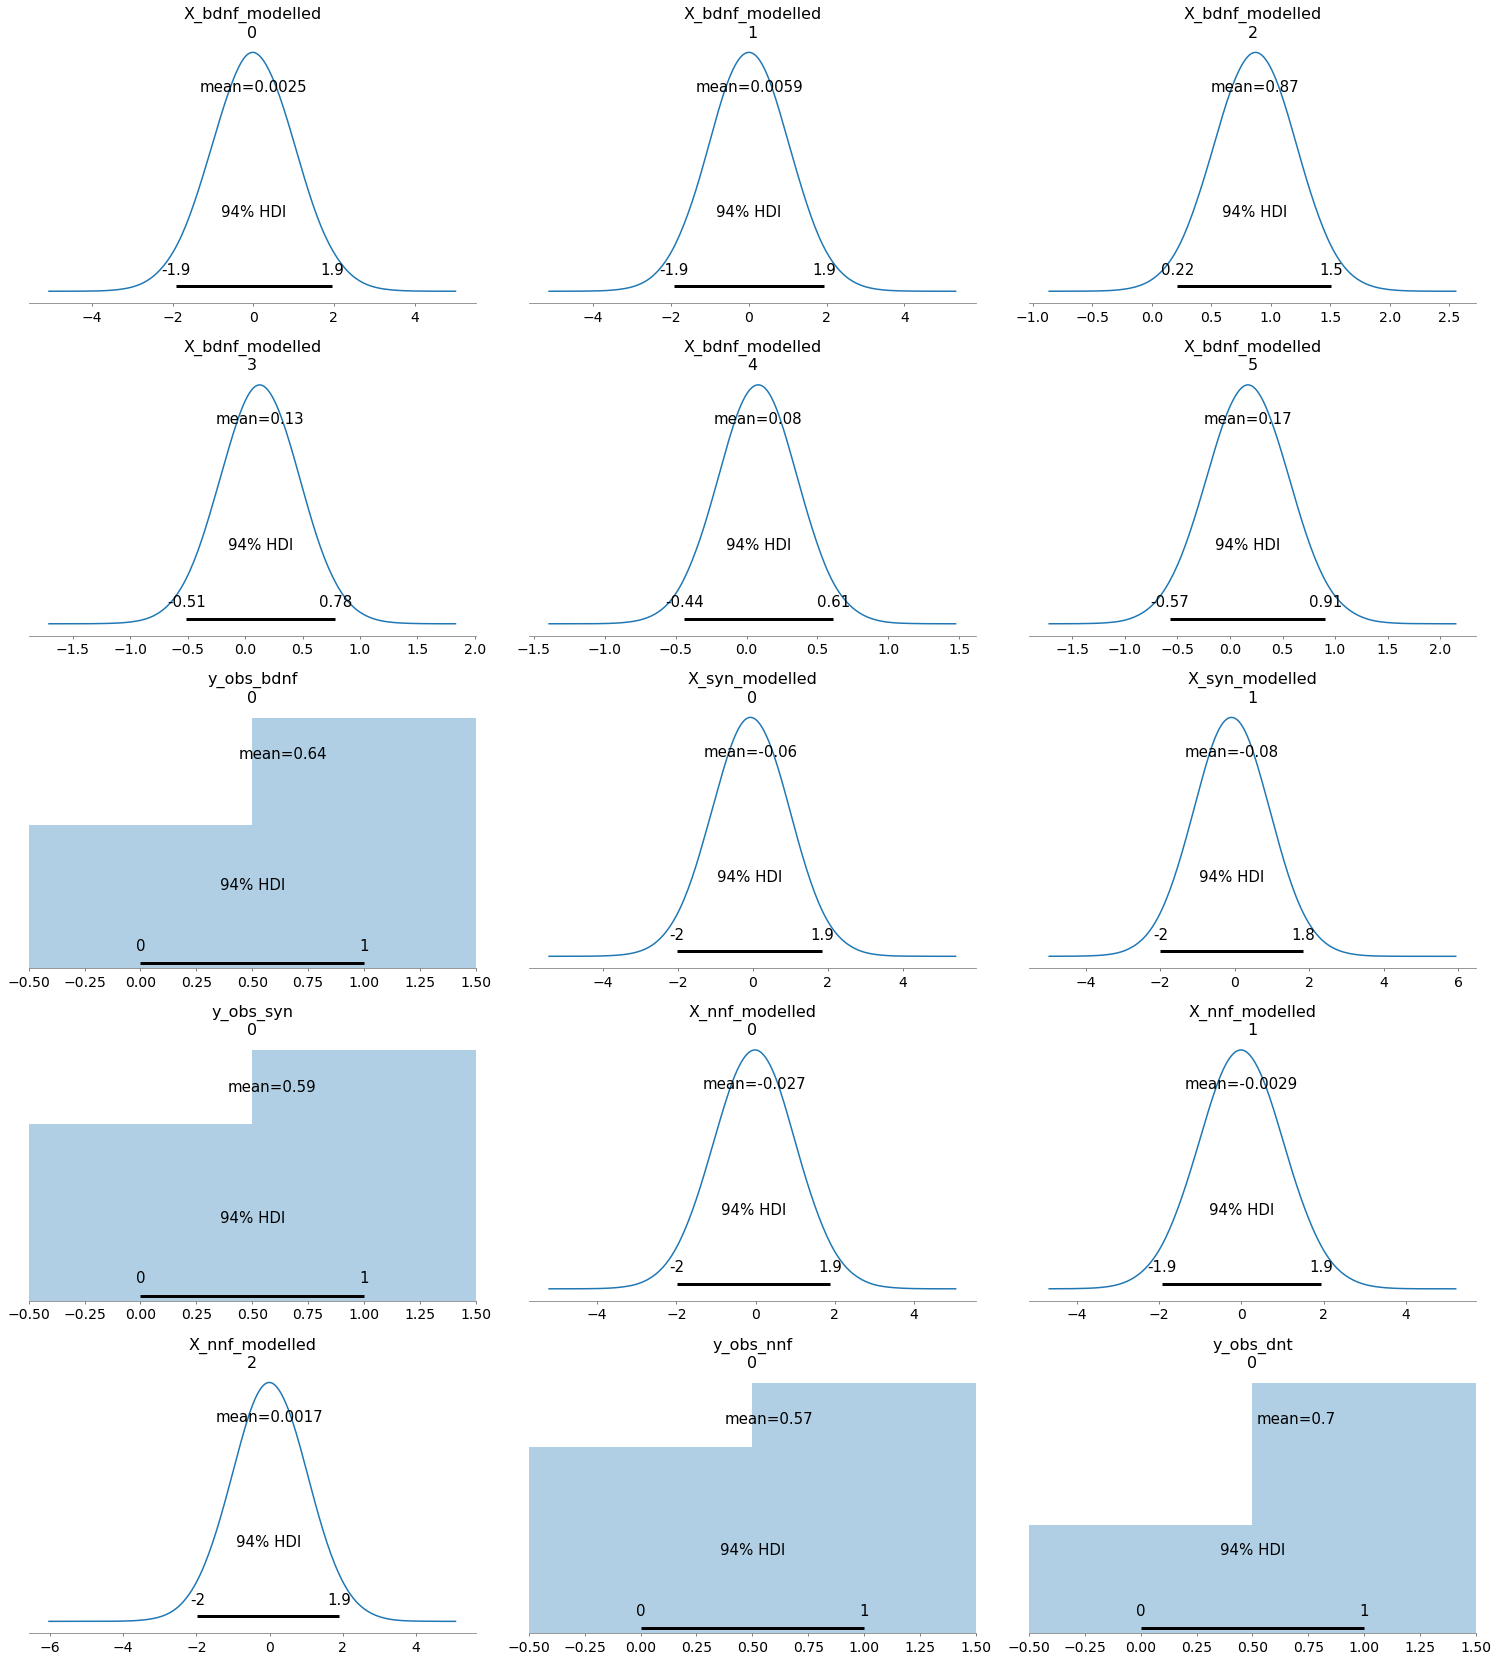

In [15]:
#Checking the posterior
pm.plot_posterior(posterior_all)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa973bb250>],
      dtype=object)

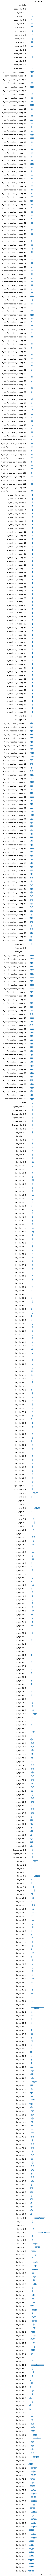

In [16]:
pm.forestplot(trace)

### Model checking

Text(0.5, 1.0, 'BFMI = 0.8892620205512078\nGelman-Rubin = 1.006913386610701')

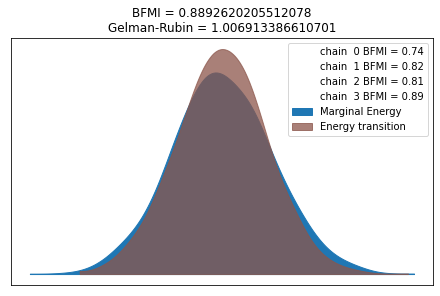

In [16]:
#Check the energy plot
bfmi = np.max(pm.stats.bfmi(trace))
max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.rhat(trace).values()).values
(pm.energyplot(trace, legend=True, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)))

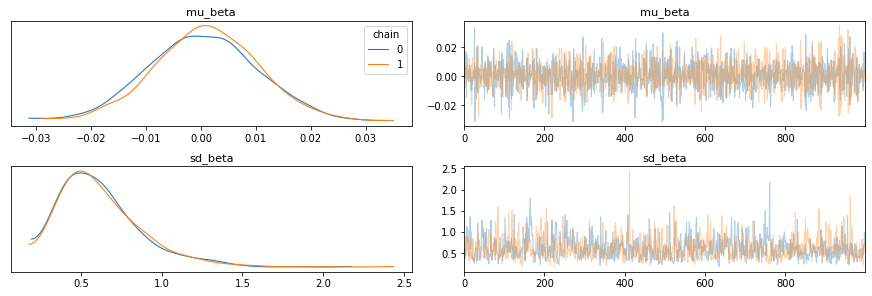

In [17]:
#Check convergence for hyperpriors of two chains
az.plot_trace(trace, var_names=['mu_beta', 'sd_beta'],
             coords={"chain":[0,1]}, legend=True)
#plt.suptitle("Trace plots")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa8187f490>,
      dtype=object)

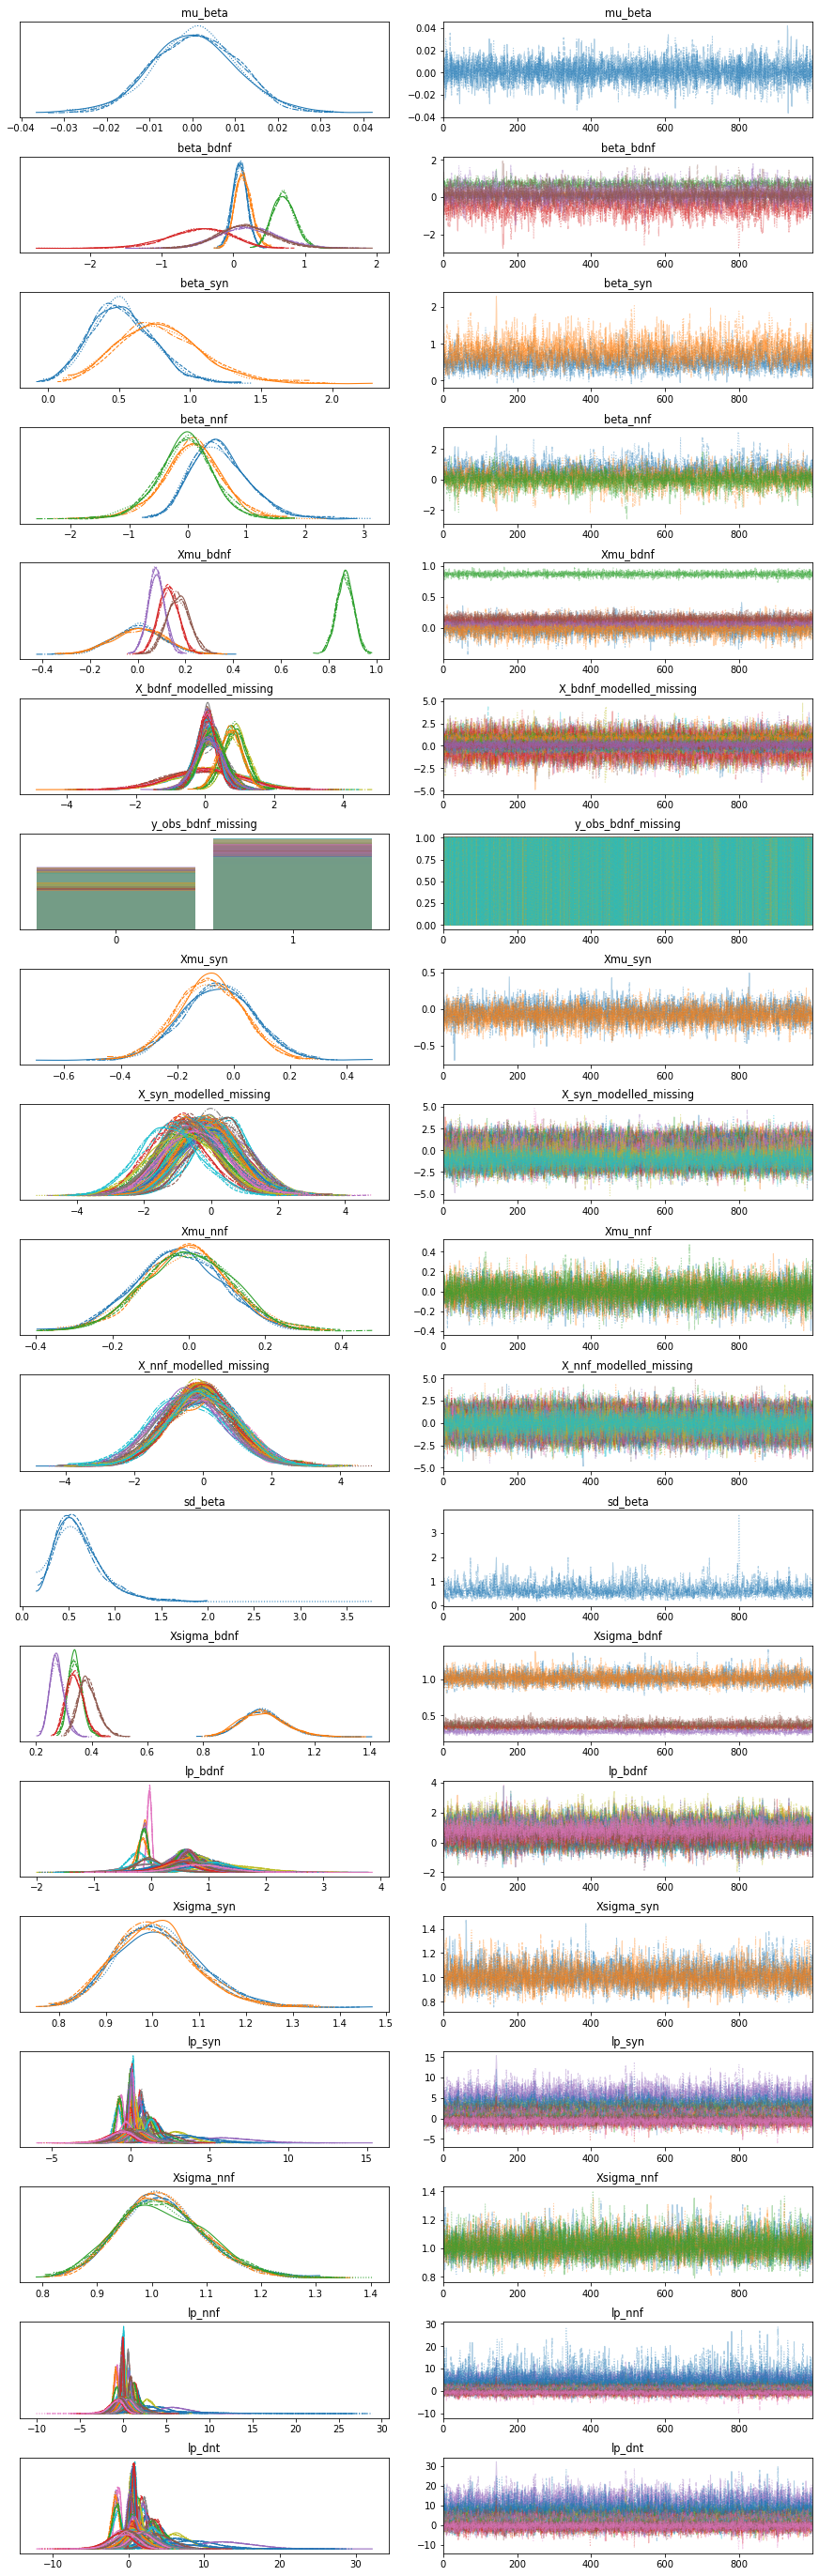

In [19]:
#Check the convergence of all parameters
pm.traceplot(trace)

### Checking statistics

In [18]:
#Statistical summary
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_beta         0.001  0.010  -0.018    0.020      0.000    0.000    5438.0   
beta_bdnf[0,0]  0.093  0.098  -0.092    0.274      0.002    0.001    3516.0   
beta_bdnf[1,0]  0.148  0.115  -0.046    0.384      0.002    0.001    3463.0   
beta_bdnf[2,0]  0.714  0.156   0.436    1.011      0.004    0.003    1257.0   
beta_bdnf[3,0] -0.485  0.426  -1.296    0.276      0.011    0.008    1386.0   
...               ...    ...     ...      ...        ...      ...       ...   
lp_dnt[92,0]   -0.043  1.546  -2.983    2.753      0.023    0.023    4372.0   
lp_dnt[93,0]   -1.312  1.695  -4.478    1.744      0.027    0.022    3806.0   
lp_dnt[94,0]    0.039  1.493  -3.002    2.623      0.021    0.023    4985.0   
lp_dnt[95,0]   -0.037  1.450  -2.692    2.801      0.023    0.021    3859.0   
lp_dnt[96,0]   -0.459  1.735  -3.790    2.704      0.030    0.027    3240.0   

                ess_sd  ess_bulk  ess_tail  r_hat  
mu_beta         1430.0    5475.0    2517.0    1.0  
beta_bdnf[0,0]  3026.0    3549.0    3022.0    1.0  
beta_bdnf[1,0]  2955.0    3524.0    3150.0    1.0  
beta_bdnf[2,0]  1159.0    1333.0    1413.0    1.0  
beta_bdnf[3,0]  1386.0    1420.0    1968.0    1.0  
...                ...       ...       ...    ...  
lp_dnt[92,0]    2177.0    4373.0    3176.0    1.0  
lp_dnt[93,0]    2924.0    3901.0    2883.0    1.0  
lp_dnt[94,0]    2117.0    4963.0    2964.0    1.0  
lp_dnt[95,0]    2365.0    3898.0    3063.0    1.0  
lp_dnt[96,0]    2015.0    3247.0    2838.0    1.0  

[698 rows x 11 columns]

In [21]:
#Helper function
def convergence_hist(hist_data):
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.hist(hist_data, bins=50, color="#1f77b4", ec="#3d5167", alpha=0.9, lw=1.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.yticks(ticks=None)

    return fig, ax

In [22]:
#R-hat
def check_rhat(inf_data, threshold=1.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["r_hat"])
    #ax.set_xlabel("Rhat statistic", labelpad=15)
    ax.set_title("$\hat{R}$")

    bad = s[s["r_hat"] > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(f"The following parameters have an Rhat greater {threshold}:\n{text}\n")
    return fig, ax

The following parameters have an Rhat greater 1.05:
None



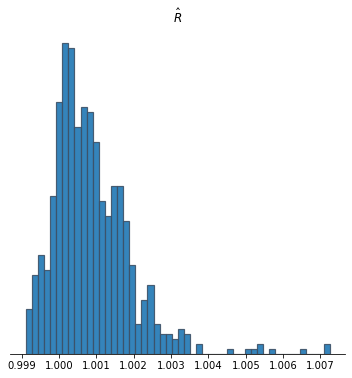

In [23]:
check_rhat(trace, threshold=1.05) #1.005 also considered
plt.show()

In [24]:
#MCSE
def check_mcse(inf_data, threshold=0.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    hist_data = s["mcse_mean"] / s["sd"]
    fig, ax = convergence_hist(hist_data)
    #ax.set_xlabel("Monte Carlo standard error / posterior sd", labelpad=15)
    ax.set_title("Monte Carlo Standard Error/Posterior sd")
    ax.locator_params(axis='x', nbins=5)

    bad = s[hist_data > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have a Monte Carlo standard error greater than {threshold * 100}% of the posterior standard deviation:\n{text}\n")
    return fig, ax

The following parameters have a Monte Carlo standard error greater than 10.0% of the posterior standard deviation:
None



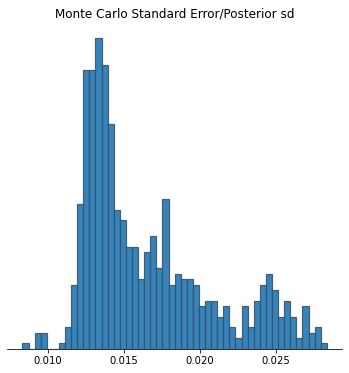

In [25]:
check_mcse(trace)
plt.show()

In [26]:
#Error related to the shape of bdnf


#ESS/NEFF, number of effective sample size
def check_neff(inf_data, threshold=0.1, verbose=True):
    N = inf_data.posterior.dims['chain'] * inf_data.posterior.dims['draw']
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["ess_mean"] / N)
    #ax.set_xlabel("Effective sample size / iterations", labelpad=15)
    ax.set_title("$n_{eff}/N$")

    bad = s[s["ess_mean"] / N < threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have an effective sample size less than {threshold * 100}% of the total sample size:\n{text}\n")
    return fig, ax

The following parameters have an effective sample size less than 10.0% of the total sample size:
None



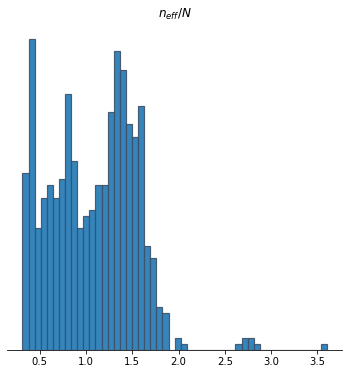

In [27]:
check_neff(trace)
plt.show()

### Goodness of fit

In [20]:
#Plot the observed vs simulated and mean

#ERROR related to strace or report

data = az.from_pymc3(trace, posterior_predictive=posterior_all, model = hierar_model1) #prior=prior_all
az.plot_ppc(data);

AttributeError: 'InferenceData' object has no attribute 'report'

### Define and fit the model for strategy II

In [21]:
with pm.Model() as hierar_model2:
    #Define hyperpriors
    mu_beta2 = pm.Normal('mu_beta2', mu=0, sd=0.01) 
    sd_beta2 = pm.HalfNormal('sd_beta2', sd=5)
    #Define priors
    beta_bdnf2 = pm.Normal('beta_bdnf2', mu=mu_beta2, sd=sd_beta2, shape=(6,1))
    beta_syn2 = pm.Normal('beta_syn2', mu=mu_beta2, sd=sd_beta2, shape=(2,1))
    beta_nnf2 = pm.Normal('beta_nnf2', mu=mu_beta2, sd=sd_beta2, shape=(3,1))

In [22]:
# ## Define bndf 
with hierar_model2: 

    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf2 = pm.Deterministic('lp_bdnf2', pm.math.dot(X_bdnf, beta_bdnf2)) 
    y_obs_bdnf2 = pm.Bernoulli('y_obs_bdnf2', logit_p=lp_bdnf2, observed=Y_bdnf)

In [23]:
# ## Define syn
with hierar_model2:
   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn2 =  pm.Deterministic('lp_syn2', lp_bdnf2 + pm.math.dot(X_syn, beta_syn2))    
    y_obs_syn2 = pm.Bernoulli("y_obs_syn2", logit_p = lp_syn2, observed=Y_syn)

In [24]:
# ## Define nnf
with hierar_model2:

    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf2 = pm.Deterministic('lp_nnf2', lp_syn2 + pm.math.dot(X_nnf, beta_nnf2))
    y_obs_nnf2 = pm.Bernoulli("y_obs_nnf2", logit_p=lp_nnf2, observed=Y_nnf)

In [25]:
# ## Define DNT
with hierar_model2:
    #Define causal relationships for DNT
    lp_dnt2 = pm.Deterministic('lp_dnt2', lp_bdnf2 + lp_syn2 + lp_nnf2)
    y_obs_dnt2 = pm.Bernoulli('y_obs_dnt2', logit_p=lp_dnt2, observed=Y_dnt)

In [26]:
#Checking the proposed structure of model
hierar_model2.check_test_point()

mu_beta2           3.69
sd_beta2_log__    -0.77
beta_bdnf2       -13.82
beta_syn2         -4.61
beta_nnf2         -6.91
y_obs_bdnf2      -67.24
y_obs_syn2       -67.24
y_obs_nnf2       -67.24
y_obs_dnt2       -67.24
Name: Log-probability of test_point, dtype: float64

In [29]:
#Make the inferences
with hierar_model2:
    trace2 = pm.sample(cores=4, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_nnf2, beta_syn2, beta_bdnf2, sd_beta2, mu_beta2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [38]:
with hierar_model2:
    posterior_all2= pm.sample_posterior_predictive(trace2)

### Model comparison

In [43]:
data1 = az.convert_to_inference_data (trace)
data2 = az.convert_to_inference_data (trace2)

In [53]:
hierar_model1_waic = az.waic(data1, hierar_model1, var_name='y_obs_syn')
hierar_model1_waic.waic

-64.53609574261006

In [54]:
hierar_model2_waic = pm.waic(data2, hierar_model2, var_name='y_obs_syn2')
hierar_model2_waic.waic

-43.817681734859306

In [57]:
hierar_model1_loo = pm.loo(data1, hierar_model1, var_name='y_obs_syn')

hierar_model1_loo.loo

-64.77244756825442

In [58]:
hierar_model2_loo = pm.loo(data2, hierar_model2, var_name='y_obs_syn2')
hierar_model2_loo.loo

-43.818221974668454

### Predictions

In [ ]:
bdnf = trace['y_obs_bdnf']
syn = trace['']
nnf = trace['']
dnt = trace['']

In [ ]:
#Helper function
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
post_bdnf = logistic(bdnf)
post_syn
post_nnf
post_dnt


In [ ]:

#https://seaborn.pydata.org/examples/pairgrid_dotplot.html
    

### Save the graphical structure, stats and traces

In [ ]:
#Save the graphical structure of the model
graph = pm.model_to_graphviz(hierar_model)
graph.render('/hierar_model_structure.gv', view=True)

In [ ]:
#Save the statistical summary of the trace
file = az.summary(trace, round_to=None)
file.to_csv('Statistical_summary_trace.csv')

In [ ]:
#Have to finalise this if it remains useful
dnt_data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior,
                    )
dnt_data.to_netcdf("dnt_hier.nc")

In [ ]:
#Save the traces
pm.save_trace(trace, directory='dnt_trace.nc')

In [59]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy   1.19.1
theano  1.0.5
pandas  1.1.1
arviz   0.9.0
seaborn 0.10.1
pymc3   3.9.3
last updated: Fri Sep 04 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
